In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch

from lerobot.configs.policies import PreTrainedConfig
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.policies.factory import get_policy_class
from lerobot.utils.utils import get_safe_torch_device


DATASET_REPO_ID = {
    "act": "zaringleb/eval_binary_cube_homelab_so101_act_12",
    "smolvla": "zaringleb/eval_binary_cube_homelab_so101_smolvla_60k_with_teleop_log1",
    "train": "zaringleb/binary_cube_homelab_so101_3"
    }["smolvla"]

dataset = LeRobotDataset(repo_id=DATASET_REPO_ID)
print(f"Loaded dataset '{DATASET_REPO_ID}' with {len(dataset)} frames and {dataset.num_episodes} episodes.")


device = get_safe_torch_device("cuda", log=True)
POLICY_PATH = {
    "smolvla": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/060000/pretrained_model",
    "act_chunk50": "outputs/train/2025-08-01/14-48-57_act_so101_test/checkpoints/020000/pretrained_model",
    "act": "outputs/train/2025-07-08/18-12-26_act_so101_test/checkpoints/020000/pretrained_model"
    }["smolvla"]


cfg = PreTrainedConfig.from_pretrained(POLICY_PATH)
policy_cls = get_policy_class(cfg.type)
policy = policy_cls.from_pretrained(POLICY_PATH)
policy.to(device)

/home/zaringleb/miniconda3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded dataset 'zaringleb/eval_binary_cube_homelab_so101_smolvla_60k_with_teleop_log1' with 1065 frames and 1 episodes.


You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Reducing the number of VLM layers to 16 ...
Loading weights from local directory


SmolVLAPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_state): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (model): VLAFlowMatching(
    (vlm_with_expert): SmolVLMWithExpertModel(
      (vlm): SmolVLMForConditionalGeneration(
        (model): SmolVLMModel(
          (vision_model): SmolVLMVisionTransformer(
            (embeddings): SmolVLMVisio

In [4]:
frame_index_inside_episode = 100
episode_id = 0

ep = torch.stack(dataset.hf_dataset["episode_index"])
first = torch.nonzero(ep == episode_id, as_tuple=False)[0].item()
last = torch.nonzero(ep == episode_id, as_tuple=False)[-1].item()
sample = dataset[first + frame_index_inside_episode]

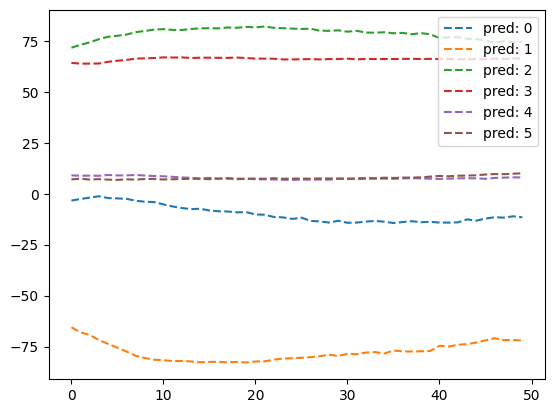

In [5]:
from offline_policy_inference import run_model_inference

predicted_actions = run_model_inference(policy, observation=sample, device=device)[0, :, :] # batch, chunk, dof


for dof in range(predicted_actions.shape[-1]):
   plt.plot(predicted_actions[:, dof], "--", label=f"pred: {dof}")

plt.legend(loc="upper right")

In [6]:
"""Loads a dataset to visualises the actions and states of a policy."""

actions_from_dataset = []
states_from_dataset = []

for idx in range(first, last + 1):
    frame = dataset[idx]
    actions_from_dataset.append(frame["action"].cpu().numpy())
    states_from_dataset.append(frame["observation.state"].cpu().numpy())

actions_from_dataset = np.array(actions_from_dataset)
states_from_dataset = np.array(states_from_dataset)

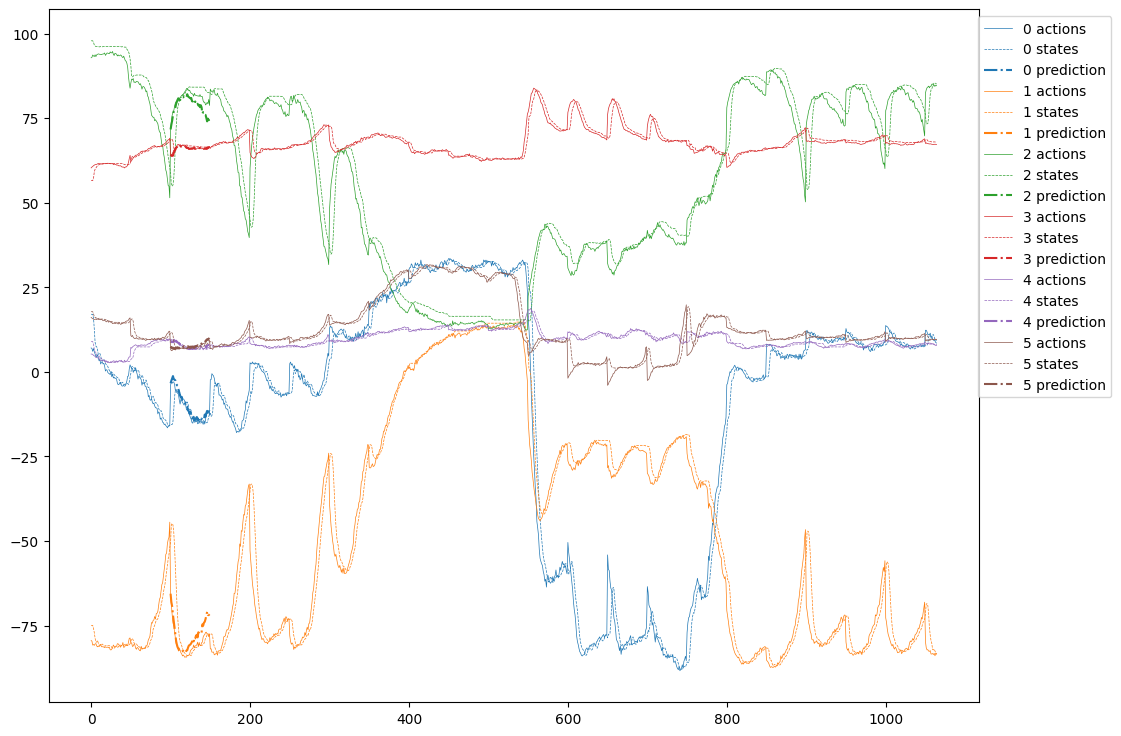

In [10]:
for dof in range(actions_from_dataset.shape[-1]):
    color = f"C{dof}"
    plt.plot(actions_from_dataset[:, dof], label=f"{dof} actions", color=color, linestyle="-", lw=0.5)
    plt.plot(states_from_dataset[:, dof], label=f"{dof} states", color=color, linestyle="--", lw=0.5)
    plt.plot(
        range(frame_index_inside_episode, frame_index_inside_episode + predicted_actions.shape[0]),
        predicted_actions[:, dof],
        label=f"{dof} prediction",
        color=color,
        linestyle="-."
    )
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.gcf().set_size_inches(12, 9)